In [599]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

from IPython.display import display

# AM205 Final Project: Options Pricing Using Black-Scholes PDEs
### Martin Reyes Holguín, Yaosheng Xu & Rebecca Qiu

## 1. European Options

### 1.1 Model

In [600]:
class EuropeanOptionModel:
    
    def __init__(self, r=0.1, sig=0.2, K=100, S0=100,
                 Texpir=1, Nspace=3000, Ntime=2000):
        self.r = r
        self.sig = sig
        self.K = K
        self.S0 = S0
        self.Texpir = Texpir
        self.Nspace = Nspace
        self.Ntime = Ntime
        
        self.X0 = np.log(S0)
        self.S_max = 3*float(K)
        self.S_min = float(K)/3
        self.x_max = np.log(self.S_max)
        self.x_min = np.log(self.S_min)
        
        self.x, self.dx = np.linspace(self.x_min, self.x_max, Nspace, retstep=True) # space discretization
        self.T, self.dt = np.linspace(0, Texpir, Ntime, retstep=True)               # time discretization
        self.S = np.exp(self.x)
        
        
    def cal_V(self, payoff: str, position: str, space_scheme="central"):
        """
        Calculate discretized value of European option V
            Input:
                payoff: 'call' or 'put'
                position: 'long' or 'short'
            return:
                Payoff (Nspace,)
                V (Nspace, Ntime)
        """
        V = np.zeros((self.Nspace, self.Ntime))
        offset = np.zeros(self.Nspace-2)
        
        # calculate Payoff and set boundary
        if position == "long" and payoff == "call":
            Payoff = np.maximum(np.exp(self.x)-self.K, 0)
            V[:,-1] = Payoff
            V[-1,:] = np.exp(self.x_max) - self.K * np.exp(-self.r* self.T[::-1])
            V[0,:] = 0
        elif position == "long" and payoff == "put":
            Payoff = np.maximum(self.K-np.exp(self.x), 0)
            V[:,-1] = Payoff
            V[-1,:] = 0
            V[0,:] = Payoff[0] * np.exp(-self.r * self.T[::-1])
        elif position == "short" and payoff == "call":
            Payoff = -np.maximum(np.exp(self.x)-self.K, 0)
            V[:,-1] = Payoff
            V[-1,:] = -np.exp(self.x_max) + self.K * np.exp(-self.r * self.T[::-1])
            V[0,:] = 0
        elif position == "short" and payoff == "put":
            Payoff = -np.maximum(self.K-np.exp(self.x), 0)
            V[:,-1] = Payoff
            V[-1,:] = 0
            V[0,:] = Payoff[0] * np.exp(-self.r * self.T[::-1])
            
        # construction of the tri-diagonal matrix D
        sig2 = self.sig * self.sig
        dxx = self.dx * self.dx

        if space_scheme == "central":
            a = ( (self.dt/2) * ( (self.r-0.5*sig2)/self.dx - sig2/dxx ) )
            b = ( 1 + self.dt * ( sig2/dxx + self.r ) )
            c = (-(self.dt/2) * ( (self.r-0.5*sig2)/self.dx + sig2/dxx ) )
        elif space_scheme == "forward":
            a = -self.dt/2 / dxx * sig2
            b = ( 1 + self.dt * (self.r/self.dx - 0.5*sig2/self.dx + sig2/dxx + self.r) )
            c = ( -self.dt * (self.r/self.dx - 0.5*sig2/self.dx + 0.5*sig2/dxx) )
        elif space_scheme == "backward":
            a = ( self.dt/self.dx * (self.r-0.5*sig2) - 0.5*self.dt/dxx*sig2 )
            b = ( 1 + self.dt * (-self.r/self.dx + 0.5*sig2/self.dx + sig2/dxx + self.r) )
            c = ( -0.5*self.dt / dxx * sig2 )
            
        D = sparse.diags([a, b, c], [-1, 0, 1], shape=(self.Nspace-2, self.Nspace-2)).tocsc()

        # Backward iteration
        for i in range(self.Ntime-2, -1, -1):
            offset[0] = a * V[0,i]
            offset[-1] = c * V[-1,i]; 
            V[1:-1,i] = spsolve(D, (V[1:-1,i+1] - offset)) 

        return Payoff, V
    
    def exact_V(self, St, t, position, payoff):
        """ Exact solution for Black-Scholes differential equation """
        sig2 = self.sig * self.sig
        d1 = (np.log(St/self.K) + (self.r+0.5*sig2)*(self.T[-1]-t/self.Ntime)) /\
                (self.sig * np.sqrt(self.T[-1]-t/self.Ntime))
        d2 = (np.log(St/self.K) + (self.r-0.5*sig2)*(self.T[-1]-t/self.Ntime)) /\
                (self.sig * np.sqrt(self.T[-1]-t/self.Ntime))
        if position == 'long' and payoff == 'call':
            return St * norm.cdf(d1) -\
                    self.K * np.exp(-self.r*(self.T[-1]-t/self.Ntime)) * norm.cdf(d2)
        elif position == 'long' and payoff == 'put':
            return -St * norm.cdf(-d1) +\
                    self.K * np.exp(-self.r*(self.T[-1]-t/self.Ntime)) * norm.cdf(-d2)
        elif position == 'short' and payoff == 'call':
            return self.K * np.exp(-self.r*(self.T[-1]-t/self.Ntime)) * norm.cdf(d2) -\
                    St * norm.cdf(d1)            
        elif position == 'short' and payoff == 'put':
            return -self.K * np.exp(-self.r*(self.T[-1]-t/self.Ntime)) * norm.cdf(-d2) +\
                    St * norm.cdf(-d1)

In [601]:
def plot_BS_price_european(t, Payoffs, Vs, positions, payoffs, space_scheme="central"):
    f, ax = plt.subplots(2, 2, figsize=(10, 10))
    for i in range(2):
        for j in range(2):
            ax[i][j].plot(european_option_model.S, Payoffs[2*i+j], color='blue',label="Payoff")
            ax[i][j].plot(european_option_model.S, Vs[2*i+j][:,t], color='red',label="BS curve")
            ax[i][j].set_xlim(50,170)
            if j==0: ax[i][j].set_ylim(0,50)
            else: ax[i][j].set_ylim(-50,0)
            ax[i][j].set_xlabel("S")
            ax[i][j].set_ylabel("price")
            ax[i][j].legend()
            ax[i][j].set_title(f"{positions[j]} {payoffs[i]} at t={t}")
    plt.suptitle(f"European Options BS Price of {space_scheme} scheme")
    plt.savefig(f"European_BS_price_{space_scheme}_t={t}")

In [602]:
def plot_exact_vs_numerical(t, Payoffs, Vs, positions, payoffs, space_scheme="central"):
    f, ax = plt.subplots(2, 2, figsize=(10, 10))
    for i in range(2):
        for j in range(2):
            exact_Vs = []
            for s in european_option_model.S:
                exact_Vs.append(european_option_model.exact_V(s, t, positions[j], payoffs[i]))
            ax[i][j].plot(european_option_model.S, Payoffs[2*i+j], color='blue',label="Payoff")
            ax[i][j].plot(european_option_model.S, Vs[2*i+j][:,t], color='red',label="BS curve")
            ax[i][j].plot(european_option_model.S, exact_Vs, color='green',label="BS exact solution")
            ax[i][j].set_xlim(50,170)
            if j==0: ax[i][j].set_ylim(0,50)
            else: ax[i][j].set_ylim(-50,0)
            ax[i][j].set_xlabel("S")
            ax[i][j].set_ylabel("price")
            ax[i][j].legend()
            ax[i][j].set_title(f"{positions[j]} {payoffs[i]} at t={t}")
    plt.suptitle(f"European Options Exact vs. Numerical Solution of {space_scheme} scheme")
    plt.savefig(f"European_exact_vs_numerical_scheme={space_scheme}_t={t}") 

In [603]:
def print_mse(t, Payoffs, Vs, positions, payoffs, space_scheme):
    print(f"For {space_scheme} scheme at t = {t}: ")
    for i in range(2):
        for j in range(2):
            loss = 0
            for index, s in enumerate(european_option_model.S):
                loss += (Vs_european[2*i+j][index,t] - european_option_model.exact_V(s, t, positions[j], payoffs[i]))**2
            MSE = loss / european_option_model.S.shape[0]
            print(f"MSE({positions[j]} {payoffs[i]}) = {MSE}")

### 1.2 Different Space Schemes

#### 1.2.1 Central Scheme

In [604]:
european_option_model = EuropeanOptionModel()
positions = ["long", "short"]
payoffs = ["call", "put"]
Payoffs_european = []
Vs_european = []  # lc, sc, lp, sp

for payoff in payoffs:
    for position in positions:
        Payoff_european, V_european = european_option_model.cal_V(payoff, position, space_scheme="central")
        Payoffs_european.append(Payoff_european)
        Vs_european.append(V_european)

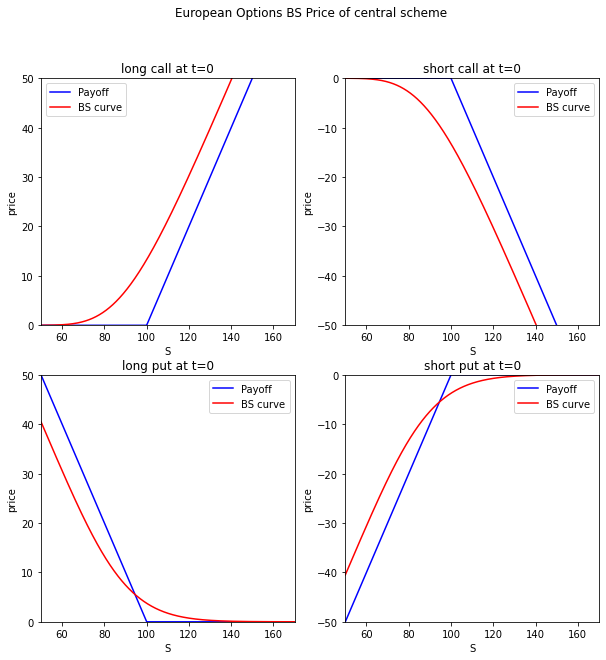

In [605]:
plot_BS_price_european(0, Payoffs_european, Vs_european, positions, payoffs, space_scheme="central")

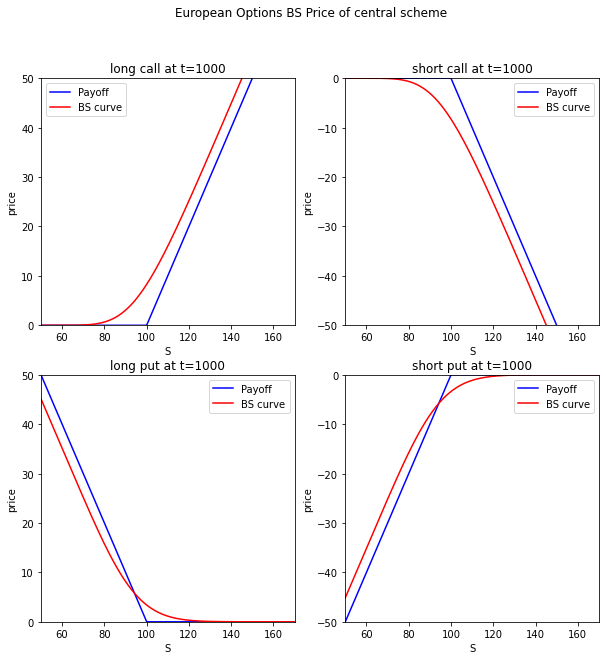

In [606]:
plot_BS_price_european(1000, Payoffs_european, Vs_european, positions, payoffs, space_scheme="central")

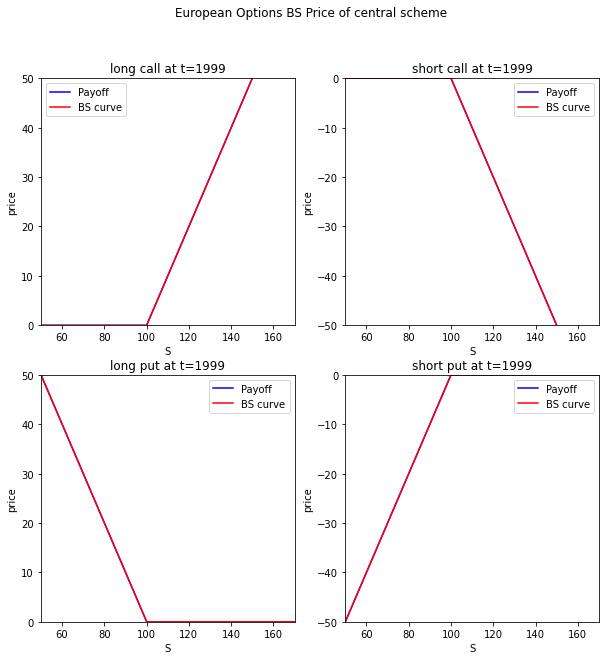

In [607]:
plot_BS_price_european(1999, Payoffs_european, Vs_european, positions, payoffs, space_scheme="central")

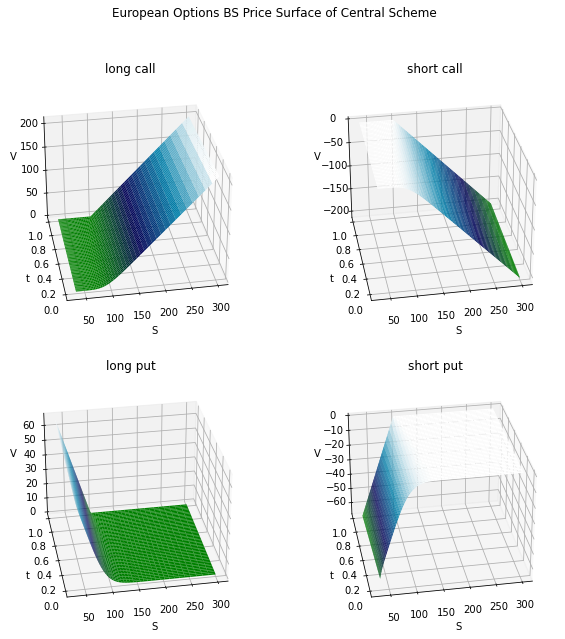

In [608]:
fig = plt.figure(figsize=(10,10))
for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(221+2*i+j, projection='3d')
        X, Y = np.meshgrid(european_option_model.T, european_option_model.S)
        ax.plot_surface(Y, X, Vs_european[2*i+j], cmap=cm.ocean)
        ax.set_title(f"{positions[j]} {payoffs[i]}")
        ax.set_xlabel("S")
        ax.set_ylabel("t")
        ax.set_zlabel("V")
        ax.view_init(30, -100)
plt.suptitle("European Options BS Price Surface of Central Scheme")
plt.savefig("European_BS_price_surface_central")

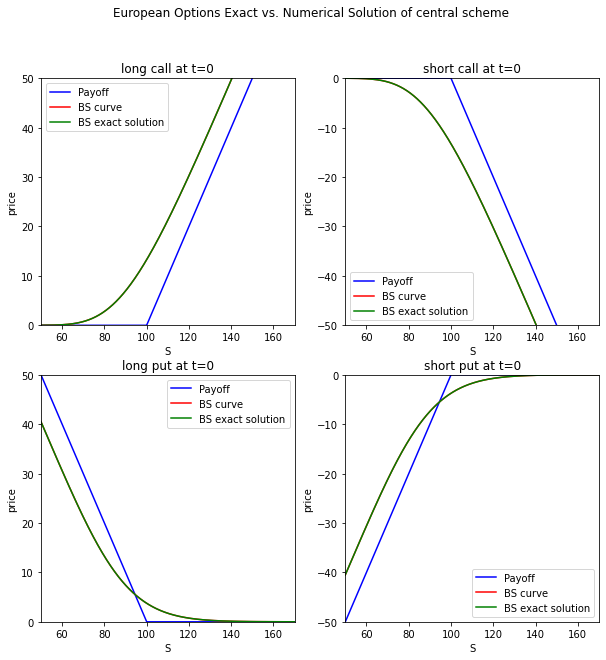

In [609]:
plot_exact_vs_numerical(0, Payoffs_european, Vs_european, positions, payoffs, 'central')

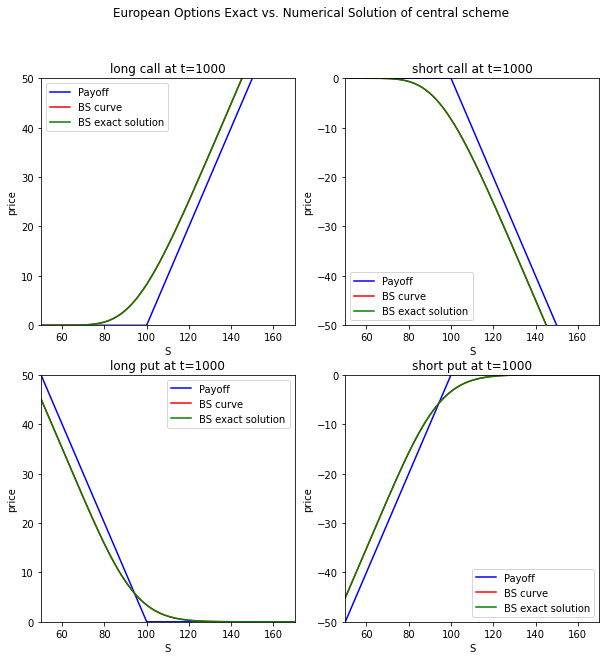

In [610]:
plot_exact_vs_numerical(1000, Payoffs_european, Vs_european, positions, payoffs, 'central')

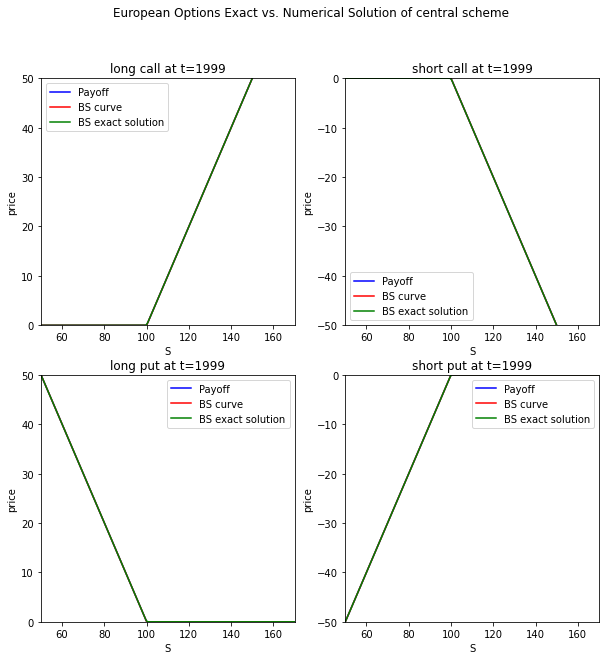

In [611]:
plot_exact_vs_numerical(1999, Payoffs_european, Vs_european, positions, payoffs, 'central')

In [612]:
print_mse(0, Payoffs_european, Vs_european, positions, payoffs, 'central')

For central scheme at t = 0: 
MSE(long call) = 1.0113273086402072e-07
MSE(short call) = 1.0113273086402072e-07
MSE(long put) = 0.21148645593720758
MSE(short put) = 0.21148645593720758


In [613]:
print_mse(1000, Payoffs_european, Vs_european, positions, payoffs, 'central')

For central scheme at t = 1000: 
MSE(long call) = 3.951392258050094e-06
MSE(short call) = 3.951392258050094e-06
MSE(long put) = 0.04226666991143163
MSE(short put) = 0.04226666991143163


In [614]:
print_mse(1999, Payoffs_european, Vs_european, positions, payoffs, 'central')

For central scheme at t = 1999: 
MSE(long call) = 5.9214910671433004e-05
MSE(short call) = 5.9214910671433004e-05
MSE(long put) = 5.4675179612994014e-05
MSE(short put) = 5.4675179612994014e-05


#### 1.2.2 Forward Scheme

In [615]:
european_option_model = EuropeanOptionModel()
positions = ["long", "short"]
payoffs = ["call", "put"]
Payoffs_european = []
Vs_european = []  # lc, sc, lp, sp

for payoff in payoffs:
    for position in positions:
        Payoff_european, V_european = european_option_model.cal_V(payoff, position, space_scheme="forward")
        Payoffs_european.append(Payoff_european)
        Vs_european.append(V_european)

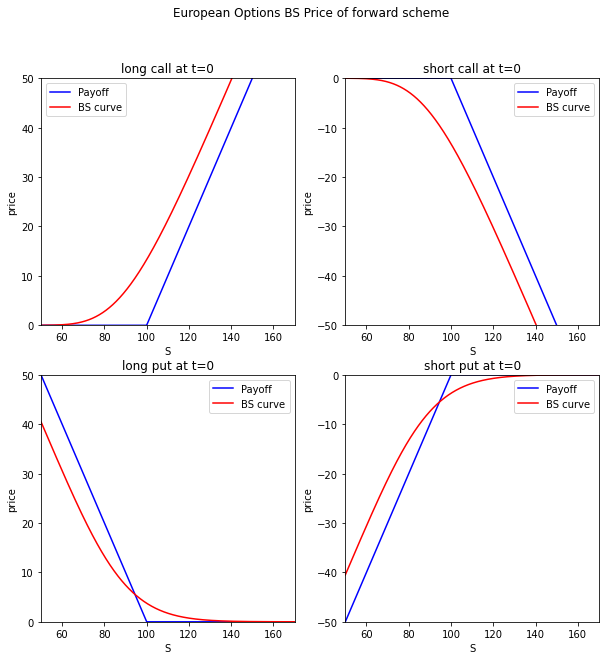

In [616]:
plot_BS_price_european(0, Payoffs_european, Vs_european, positions, payoffs, space_scheme="forward")

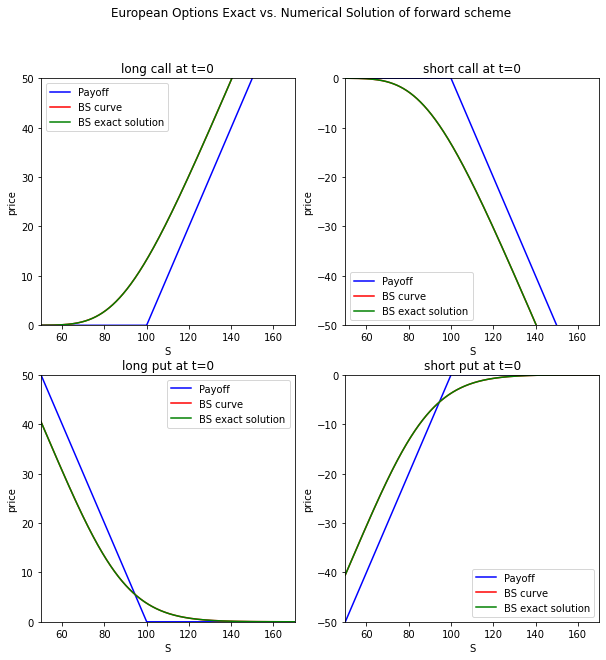

In [617]:
plot_exact_vs_numerical(0, Payoffs_european, Vs_european, positions, payoffs, 'forward')

In [618]:
print_mse(0, Payoffs_european, Vs_european, positions, payoffs, 'forward')

For forward scheme at t = 0: 
MSE(long call) = 1.748007132601301e-05
MSE(short call) = 1.748007132601301e-05
MSE(long put) = 0.211535800361691
MSE(short put) = 0.211535800361691


#### 1.2.3 Backward Scheme

In [619]:
european_option_model = EuropeanOptionModel()
positions = ["long", "short"]
payoffs = ["call", "put"]
Payoffs_european = []
Vs_european = []  # lc, sc, lp, sp

for payoff in payoffs:
    for position in positions:
        Payoff_european, V_european = european_option_model.cal_V(payoff, position, space_scheme="backward")
        Payoffs_european.append(Payoff_european)
        Vs_european.append(V_european)

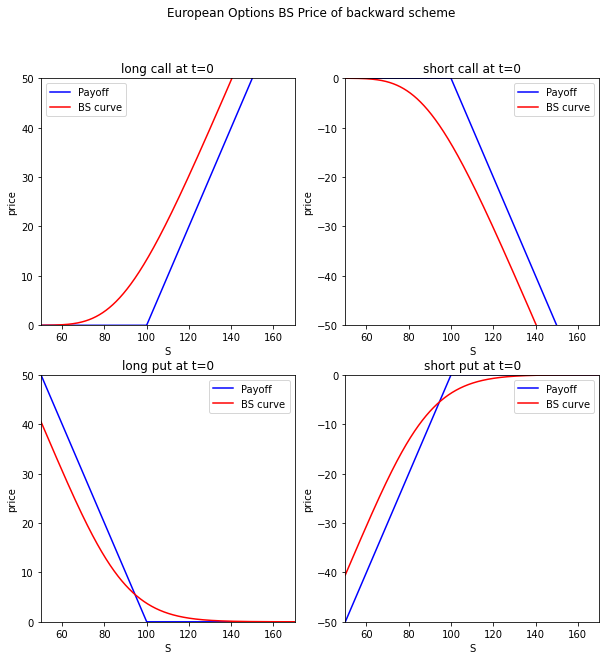

In [620]:
plot_BS_price_european(0, Payoffs_european, Vs_european, positions, payoffs, space_scheme="backward")

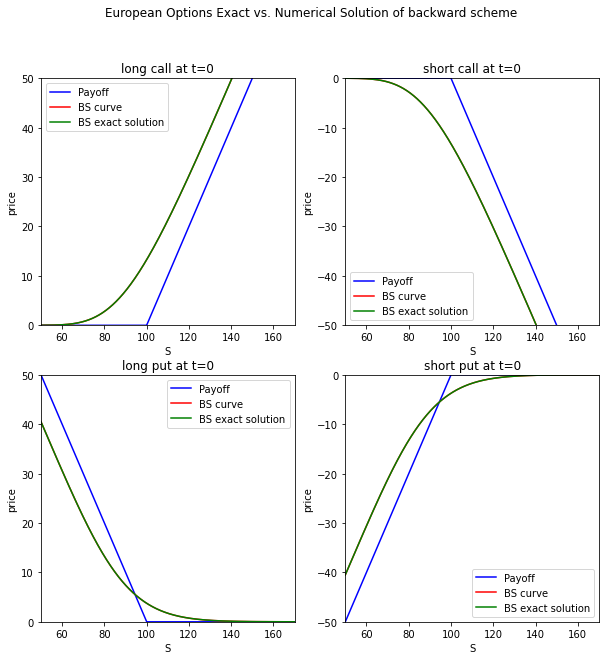

In [621]:
plot_exact_vs_numerical(0, Payoffs_european, Vs_european, positions, payoffs, 'backward')

In [622]:
print_mse(0, Payoffs_european, Vs_european, positions, payoffs, 'backward')

For backward scheme at t = 0: 
MSE(long call) = 1.991173785618039e-05
MSE(short call) = 1.991173785618039e-05
MSE(long put) = 0.21144258121428852
MSE(short put) = 0.21144258121428852


## 2. Ameican Options

### 2.1 Model

In [623]:
class AmericanOptionModel:
    
    def __init__(self, r=0.1, sig=0.2, K=100, S0=100,
                 Texpir=1, Nspace=3000, Ntime=2000):
        self.r = r
        self.sig = sig
        self.K = K
        self.S0 = S0
        self.Texpir = Texpir
        self.Nspace = Nspace
        self.Ntime = Ntime
        
        self.X0 = np.log(S0)
        self.S_max = 3*float(K)
        self.S_min = float(K)/3
        self.x_max = np.log(self.S_max)
        self.x_min = np.log(self.S_min)
        
        self.x, self.dx = np.linspace(self.x_min, self.x_max, Nspace, retstep=True) # space discretization
        self.T, self.dt = np.linspace(0, Texpir, Ntime, retstep=True)               # time discretization
        self.S = np.exp(self.x)
        
        
    def cal_V(self, payoff: str, position: str):
        """
        Calculate discretized value of American option V
            Input:
                payoff: 'call' or 'put'
                position: 'long' or 'short'
            return:
                Payoff (Nspace,)
                V (Nspace, Ntime)
        """
        V = np.zeros((self.Nspace, self.Ntime))
        offset = np.zeros(self.Nspace-2)
        
        # calculate Payoff and set boundary
        if position == "long" and payoff == "call":
            Payoff = np.maximum(np.exp(self.x)-self.K, 0)
            V[:,-1] = Payoff
            V[-1,:] = np.exp(self.x_max) - self.K * np.exp(-self.r* self.T[::-1])
            V[0,:] = 0
        elif position == "long" and payoff == "put":
            Payoff = np.maximum(self.K-np.exp(self.x), 0)
            V[:,-1] = Payoff
            V[-1,:] = 0
            V[0,:] = Payoff[0] * np.exp(-self.r * self.T[::-1])
        elif position == "short" and payoff == "call":
            Payoff = -np.maximum(np.exp(self.x)-self.K, 0)
            V[:,-1] = Payoff
            V[-1,:] = -np.exp(self.x_max) + self.K * np.exp(-self.r * self.T[::-1])
            V[0,:] = 0
        elif position == "short" and payoff == "put":
            Payoff = -np.maximum(self.K-np.exp(self.x), 0)
            V[:,-1] = Payoff
            V[-1,:] = 0
            V[0,:] = Payoff[0] * np.exp(-self.r * self.T[::-1])
            
        # construction of the tri-diagonal matrix D
        sig2 = self.sig * self.sig
        dxx = self.dx * self.dx
        
        # using central difference scheme only
        a = ( (self.dt/2) * ( (self.r-0.5*sig2)/self.dx - sig2/dxx ) )
        b = ( 1 + self.dt * ( sig2/dxx + self.r ) )
        c = (-(self.dt/2) * ( (self.r-0.5*sig2)/self.dx + sig2/dxx ) )

        D = sparse.diags([a, b, c], [-1, 0, 1], shape=(self.Nspace-2, self.Nspace-2)).tocsc()

        # Backward iteration
        for i in range(self.Ntime-2, -1, -1):
            offset[0] = a * V[0,i]
            offset[-1] = c * V[-1,i]; 
            V[1:-1,i] = np.maximum(spsolve(D, (V[1:-1,i+1] - offset)), Payoff[1:-1]) 

        return Payoff, V
    
    def exact_V(self, St, t, position):
        """ Exact solution for an optimally early-exercised American put option """
        sig2 = self.sig * self.sig
        d1 = (np.log(St/self.K) + (self.r+0.5*sig2)*(self.T[-1]-t/self.Ntime)) /\
                (self.sig * np.sqrt(self.T[-1]-t/self.Ntime))
        d2 = (np.log(St/self.K) + (self.r-0.5*sig2)*(self.T[-1]-t/self.Ntime)) /\
                (self.sig * np.sqrt(self.T[-1]-t/self.Ntime))
        d3 = (np.log(St/self.K) + 0.5*sig2*(self.T[-1]-t/self.Ntime)) /\
                (self.sig * np.sqrt(self.T[-1]-t/self.Ntime))
        d4 = (np.log(St/self.K) -0.5*sig2*(self.T[-1]-t/self.Ntime)) /\
                (self.sig * np.sqrt(self.T[-1]-t/self.Ntime))
        if position == 'long':
            return (self.K*norm.cdf(-d4) - St*norm.cdf(-d3))*norm.cdf(-d4) +\
                    np.maximum(-St * norm.cdf(-d1) + self.K * np.exp(-self.r*(self.T[-1]-t/self.Ntime)) *\
                    norm.cdf(-d2), self.K-St) * norm.cdf(d4)          
        elif position == 'short':
            return -(self.K*norm.cdf(-d4) - St*norm.cdf(-d3))*norm.cdf(-d4) -\
                    np.maximum(-self.K * np.exp(-self.r*(self.T[-1]-t/self.Ntime)) * norm.cdf(-d2) +\
                    St * norm.cdf(-d1), self.K-St) * norm.cdf(d4)

In [624]:
def plot_BS_price_American(t, Payoffs, Vs, positions, payoffs):
    f, ax = plt.subplots(2, 2, figsize=(10, 10))
    for i in range(2):
        for j in range(2):
            ax[i][j].plot(american_option_model.S, Payoffs[2*i+j], color='blue',label="Payoff")
            ax[i][j].plot(american_option_model.S, Vs[2*i+j][:,t], color='red',label="BS curve")
            ax[i][j].set_xlim(50,170)
            if j==0: ax[i][j].set_ylim(0,50)
            else: ax[i][j].set_ylim(-50,0)
            ax[i][j].set_xlabel("S")
            ax[i][j].set_ylabel("price")
            ax[i][j].legend()
            ax[i][j].set_title(f"{positions[j]} {payoffs[i]} at t={t}")
    plt.suptitle("American Options BS Price")
    plt.savefig(f"American_BS_Price_t={t}")

In [625]:
def plot_exact_vs_numerical_american(t, Payoffs, Vs):
    positions = ["long", "short"]
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    for i in range(2):
        exact_Vs = []
        for s in american_option_model.S:
            exact_Vs.append(american_option_model.exact_V(s, t, positions[i]))
        ax[i].plot(american_option_model.S, Payoffs[i+2], color='blue',label="Payoff")
        ax[i].plot(american_option_model.S, Vs[i+2][:,t], color='red',label="BS curve")
        ax[i].plot(american_option_model.S, exact_Vs, color='green',label="BS exact solution")
        ax[i].set_xlim(50,170)
        if i==0: ax[i].set_ylim(0,50)
        else: ax[i].set_ylim(-50,0)
        ax[i].set_xlabel("S")
        ax[i].set_ylabel("price")
        ax[i].legend()
        ax[i].set_title(f"{positions[i]} put at t={t}")
    plt.suptitle(f"American Put Options Exact vs. Numerical Solution Using Optimal Early Exercise")
    plt.savefig(f"American_exact_vs_numerical_t={t}") 

In [626]:
def print_mse_american(t, Payoffs, Vs):
    positions = ["long", "short"]
    print(f"For an optimally early-exercised American option at t = {t}: ")
    for i in range(2):
        loss = 0
        for index, s in enumerate(american_option_model.S[2:]):
            loss += (Vs_american[i+2][index,t] - american_option_model.exact_V(s, t, positions[i]))**2
        MSE = loss / american_option_model.S.shape[0]
        print(f"MSE({positions[i]} put) = {MSE}")

In [627]:
american_option_model = AmericanOptionModel()
positions = ["long", "short"]
payoffs = ["call", "put"]
Payoffs_american = []
Vs_american = []  # lc, sc, lp, sp

for payoff in payoffs:
    for position in positions:
        Payoff_american, V_american = american_option_model.cal_V(payoff, position)
        Payoffs_american.append(Payoff_american)
        Vs_american.append(V_american)

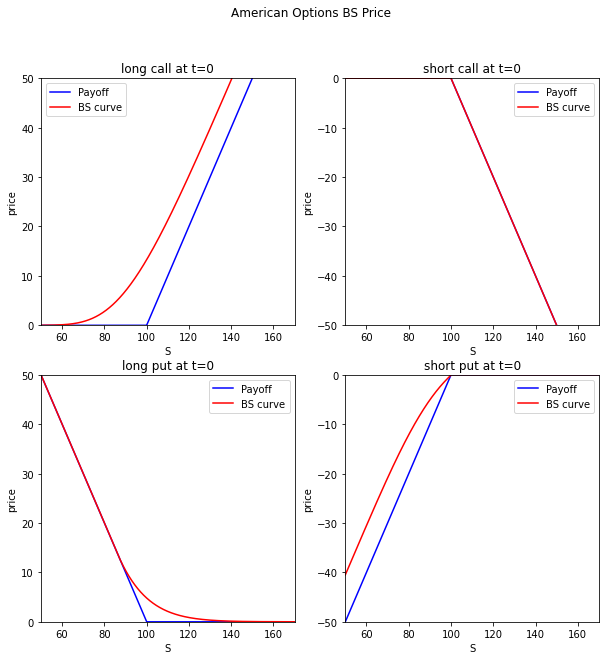

In [628]:
plot_BS_price_American(0, Payoffs_american, Vs_american, positions, payoffs)

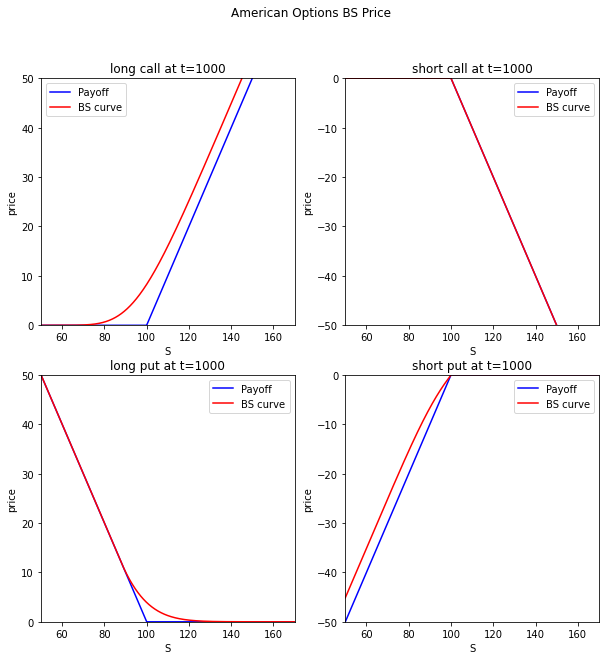

In [629]:
plot_BS_price_American(1000, Payoffs_american, Vs_american, positions, payoffs)

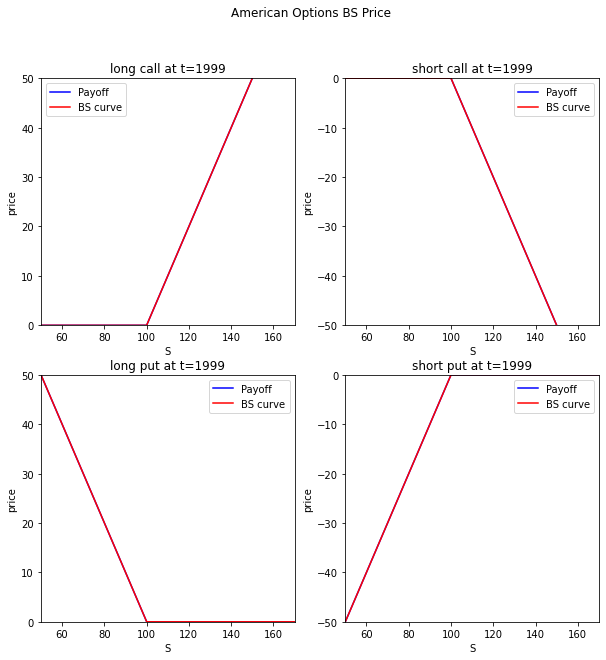

In [630]:
plot_BS_price_American(1999, Payoffs_american, Vs_american, positions, payoffs)

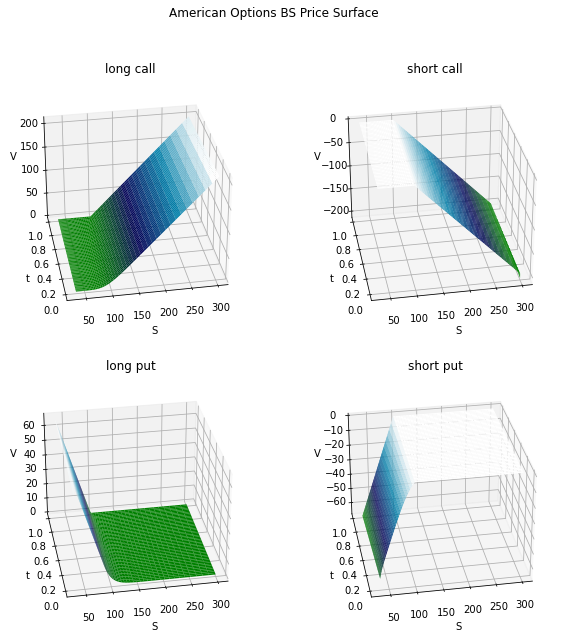

In [631]:
fig = plt.figure(figsize=(10,10))
for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(221+2*i+j, projection='3d')
        X, Y = np.meshgrid(american_option_model.T, american_option_model.S)
        ax.plot_surface(Y, X, Vs_american[2*i+j], cmap=cm.ocean)
        ax.set_title(f"{positions[j]} {payoffs[i]}")
        ax.set_xlabel("S")
        ax.set_ylabel("t")
        ax.set_zlabel("V")
        ax.view_init(30, -100)
plt.suptitle("American Options BS Price Surface")
plt.savefig("American_BS_price_surface")

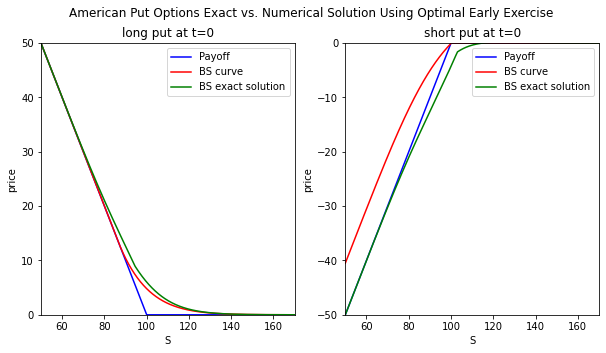

In [632]:
plot_exact_vs_numerical_american(0, Payoffs_american, Vs_american)

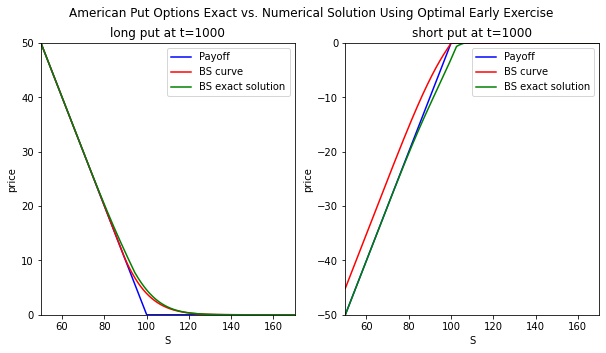

In [637]:
plot_exact_vs_numerical_american(1000, Payoffs_american, Vs_american)

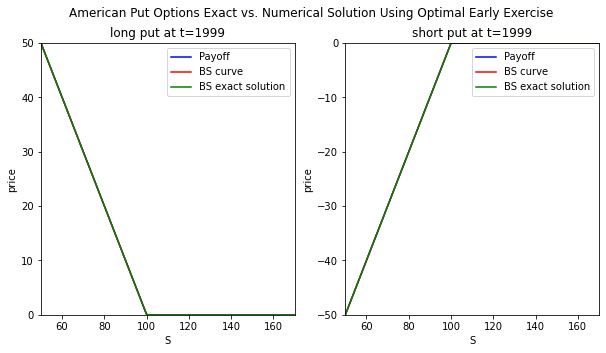

In [633]:
plot_exact_vs_numerical_american(1999, Payoffs_american, Vs_american)

In [634]:
print_mse_american(0, Payoffs_american, Vs_american)

For an optimally early-exercised American option at t = 0: 
MSE(long put) = 0.3361013819656262
MSE(short put) = 38.3938235207546


In [636]:
print_mse_american(1000, Payoffs_american, Vs_american)

For an optimally early-exercised American option at t = 1000: 
MSE(long put) = 0.07840086639662198
MSE(short put) = 10.728448019176101


In [635]:
print_mse_american(1999, Payoffs_american, Vs_american)

For an optimally early-exercised American option at t = 1999: 
MSE(long put) = 0.0043019246648554246
MSE(short put) = 0.00430102876013778
